In [1]:
from pathlib import Path

import awkward as ak
import numpy as np

import h5py as h5

import numba as nb


import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams.update({"font.size": 16})

In [2]:
proj_dir = Path.cwd().parent.parent

test_file = proj_dir.joinpath('reports/bv2/hhh_test.h5')
pred_file = proj_dir.joinpath('reports/bv2/pred_v22.h5')

plot_dir = proj_dir.joinpath('reports/bv2/figures')

In [3]:
testfile = h5.File(test_file)
predfile = h5.File(pred_file)

In [4]:
testfile['TARGETS']['h1'].keys()

<KeysViewHDF5 ['b1', 'b2', 'mask', 'pt']>

In [5]:
predfile['TARGETS']['bh2'].keys()

<KeysViewHDF5 ['assignment_probability', 'bb', 'detection_probability', 'marginal_probability']>

In [6]:
testfile['INPUTS']['BoostedJets'].keys()

<KeysViewHDF5 ['MASK', 'fj_charge', 'fj_chargedenergyfrac', 'fj_cosphi', 'fj_ehadovereem', 'fj_eta', 'fj_mass', 'fj_ncharged', 'fj_neutralenergyfrac', 'fj_nneutral', 'fj_phi', 'fj_pt', 'fj_sdmass', 'fj_sinphi', 'fj_tau21', 'fj_tau32']>

In [7]:
predfile["TARGETS"]["bh1"]['bb'][0:100]

array([ 0,  6,  6, 10, 10,  4,  2,  6, 11,  7,  5, 10,  1,  6,  7, 10, 10,
        6, 10,  0, 10,  5,  1,  1,  6,  4, 12,  3, 11, 10, 11, 10, 10,  4,
       10, 10, 10, 10, 10,  4,  8,  0,  1,  1,  6, 10,  6, 10,  2,  1,  0,
       11,  3,  7,  3,  9, 10,  5, 10,  4,  5,  0,  6,  0, 11, 12,  0, 11,
        6,  0, 11,  2,  2, 10, 11,  8,  0,  3,  7, 10,  1, 10,  4, 11, 10,
        3, 10,  6,  0,  5, 10, 10,  0,  1, 11, 10,  0,  0,  1,  5])

In [8]:
testfile["TARGETS"]["bh1"]['mask'][0:100]

array([False, False,  True, False, False, False, False, False,  True,
        True, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [9]:
testfile["TARGETS"]["bh1"]['bb'][0:100]

array([-1, -1,  0, -1, -1, -1, -1, -1,  0,  1, -1, -1, -1, -1, -1, -1,  0,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

### Test if indices in pred bb are out of boundary for target mask =True

In [10]:
print(np.unique(predfile["TARGETS"]["bh3"]['bb'][:]))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [11]:
print(np.unique(testfile["TARGETS"]["bh3"]['bb'][:]))

[-1  0  1  2]


### OptionL: examaine pt order

### Obtain python arrays for calculating purity and efficiency

In [12]:
# Collect H pt, mask, target and predicted jet and fjets for 3 Hs in each event
# h pt
h1_pt = np.array(testfile['TARGETS']['h1']['pt'])
h2_pt = np.array(testfile['TARGETS']['h2']['pt'])
h3_pt = np.array(testfile['TARGETS']['h3']['pt'])

bh1_pt = np.array(testfile['TARGETS']['bh1']['pt'])
bh2_pt = np.array(testfile['TARGETS']['bh2']['pt'])
bh3_pt = np.array(testfile['TARGETS']['bh3']['pt'])

# mask
h1_mask = np.array(testfile['TARGETS']['h1']['mask'])
h2_mask = np.array(testfile['TARGETS']['h2']['mask'])
h3_mask = np.array(testfile['TARGETS']['h3']['mask'])

bh1_mask = np.array(testfile['TARGETS']['bh1']['mask'])
bh2_mask = np.array(testfile['TARGETS']['bh2']['mask'])
bh3_mask = np.array(testfile['TARGETS']['bh3']['mask'])

# target jet/fjets
b1_h1_t = np.array(testfile["TARGETS"]["h1"]['b1'])
b1_h2_t = np.array(testfile["TARGETS"]["h2"]['b1'])
b1_h3_t = np.array(testfile["TARGETS"]["h3"]['b1'])

b2_h1_t = np.array(testfile["TARGETS"]["h1"]['b2'])
b2_h2_t = np.array(testfile["TARGETS"]["h2"]['b2'])
b2_h3_t = np.array(testfile["TARGETS"]["h3"]['b2'])

bb_bh1_t = np.array(testfile["TARGETS"]["bh1"]['bb'])
bb_bh2_t = np.array(testfile["TARGETS"]["bh2"]['bb'])
bb_bh3_t = np.array(testfile["TARGETS"]["bh3"]['bb'])

# pred jet/fjets
b1_h1_p = np.array(predfile["TARGETS"]["h1"]['b1'])
b1_h2_p = np.array(predfile["TARGETS"]["h2"]['b1'])
b1_h3_p = np.array(predfile["TARGETS"]["h3"]['b1'])

b2_h1_p = np.array(predfile["TARGETS"]["h1"]['b2'])
b2_h2_p = np.array(predfile["TARGETS"]["h2"]['b2'])
b2_h3_p = np.array(predfile["TARGETS"]["h3"]['b2'])

bb_bh1_p = np.array(predfile["TARGETS"]["bh1"]['bb'])
bb_bh2_p = np.array(predfile["TARGETS"]["bh2"]['bb'])
bb_bh3_p = np.array(predfile["TARGETS"]["bh3"]['bb'])


# fatjet assignment probability
ap_bh1 = np.array(predfile["TARGETS"]["bh1"]['assignment_probability'])
ap_bh2 = np.array(predfile["TARGETS"]["bh2"]['assignment_probability'])
ap_bh3 = np.array(predfile["TARGETS"]["bh3"]['assignment_probability'])

In [13]:
fj_pts = np.array(predfile["INPUTS"]["BoostedJets"]["fj_pt"])

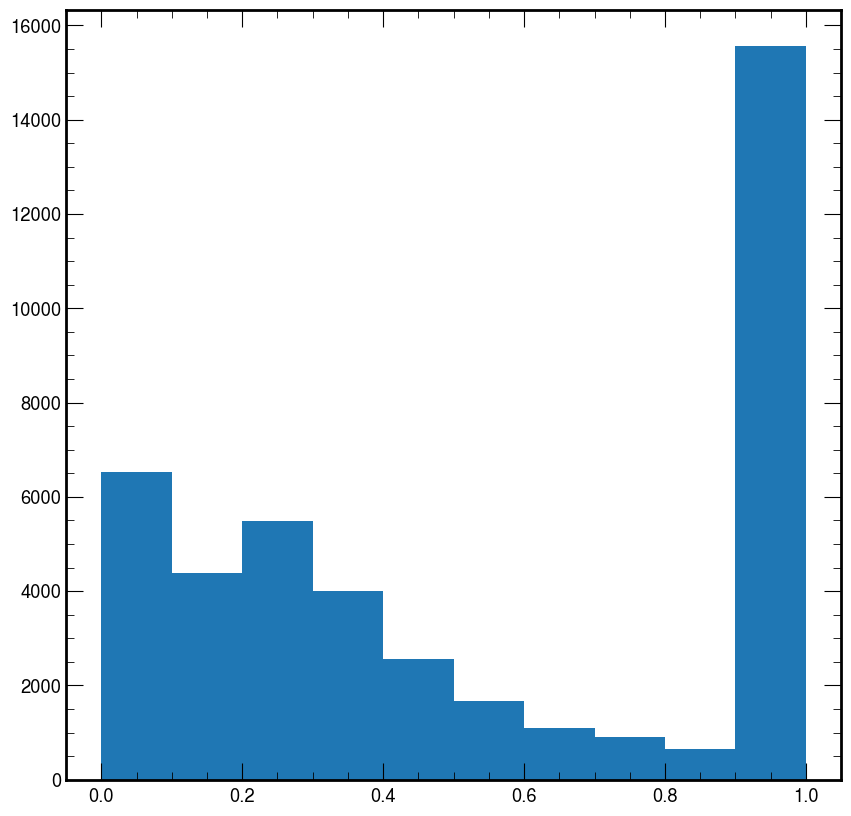

In [14]:
plt.hist(ap_bh1)
plt.show()

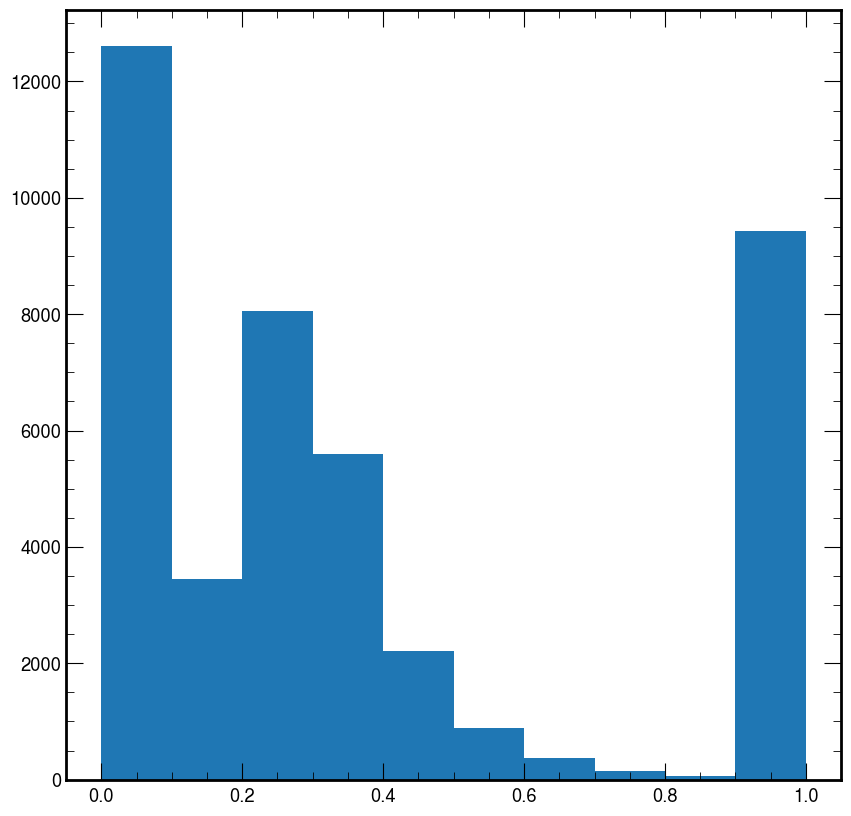

In [15]:
plt.hist(ap_bh2)
plt.show()

# Calculating efficiency (denominator should be pred)

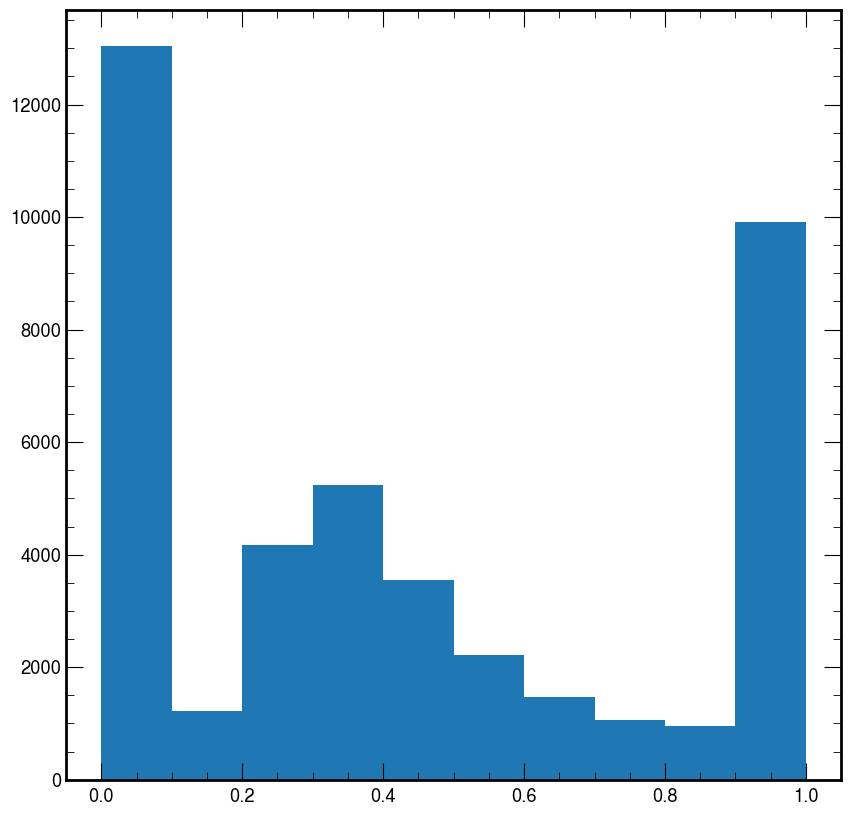

In [16]:
plt.hist(ap_bh3)
plt.show()

### As prediction h1 can be matched to target h1, 2, 3,  I will do things in the event level first

In [17]:
# convert some arrays to ak array
aps = np.concatenate((ap_bh1.reshape(-1,1), ap_bh2.reshape(-1,1), ap_bh3.reshape(-1,1)), axis=1)
aps = ak.Array(aps)
bb_ps = np.concatenate((bb_bh1_p.reshape(-1,1), bb_bh2_p.reshape(-1,1), bb_bh3_p.reshape(-1,1)), axis=1)
bb_ps = ak.Array(bb_ps)
bb_ts = np.concatenate((bb_bh1_t.reshape(-1,1), bb_bh2_t.reshape(-1,1), bb_bh3_t.reshape(-1,1)), axis=1)
bb_ts = ak.Array(bb_ts)
fj_pts = ak.Array(fj_pts)

# p: prediction
AP_threshold = 0.5
ap_filter = aps > AP_threshold
bb_ps_passed = bb_ps.mask[ap_filter]
bb_ps_passed = ak.drop_none(bb_ps_passed)

aps_passed = aps.mask[ap_filter]
aps_passed = ak.drop_none(aps_passed)

sort_by_ap = ak.argsort(aps_passed, axis=-1, ascending=False)
bb_ps_passed = bb_ps_passed[sort_by_ap]

In [18]:
bh_effs = []
# for each event
for bb_p_event, bb_t_event, fj_pt_event in zip(bb_ps_passed, bb_ts, fj_pts):
    # for each predicted fatjet, check if the targets have a t fatject same with the p fatjet
    for bb_p in bb_p_event:
        match = 0
        for bb_t in bb_t_event:
            if bb_p == bb_t+10:
                match = 1
        bh_effs.append([fj_pt_event[bb_t], match])
bh_effs = np.array(bh_effs)

In [19]:
# set x axis (pT) of the scattered points
bins = np.arange(200, 1000, 100)
bin_centers = [(bins[i]+bins[i+1])/2 for i in range(bins.size-1)]

# group points into bins by fatjet pT
eff_inds = np.digitize(bh_effs[:,0], bins)

#np.concatenate((ap_bh1.reshape(-1,1), ap_bh2.reshape(-1,1), ap_bh3.reshape(-1,1)), axis=1)
effs_per_bin = []
for bin_i in range(1, len(bins)):
    effs_per_bin.append(bh_effs[:,1][eff_inds==bin_i])
effs_per_bin = ak.Array(effs_per_bin)

In [20]:
for effs, bin_c in zip(effs_per_bin, bin_centers):
    print(f"{ak.sum(effs)} out of {ak.count(effs)} assignment are same with target in bin centered at {bin_c} GeV")

1660.0 out of 5273 assignment are same with target in bin centered at 250.0 GeV
1601.0 out of 2767 assignment are same with target in bin centered at 350.0 GeV
850.0 out of 1345 assignment are same with target in bin centered at 450.0 GeV
381.0 out of 584 assignment are same with target in bin centered at 550.0 GeV
197.0 out of 309 assignment are same with target in bin centered at 650.0 GeV
92.0 out of 157 assignment are same with target in bin centered at 750.0 GeV
54.0 out of 91 assignment are same with target in bin centered at 850.0 GeV


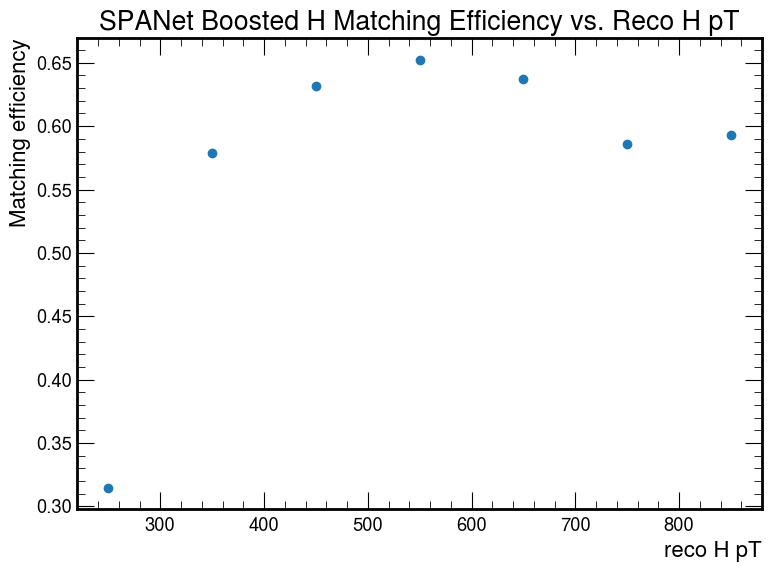

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x=bin_centers, y=ak.mean(effs_per_bin, axis=-1))
ax.set(xlabel=r"reco H pT", ylabel=r"Matching efficiency", title="SPANet Boosted H Matching Efficiency vs. Reco H pT")
plt.tight_layout()
plt.savefig(f"{str(plot_dir)}/test_efficiency.jpg")

In [22]:
ak.std(effs_per_bin, axis=-1)

<Array [0.464, 0.494, 0.482, ..., 0.481, 0.493, 0.491] type='7 * float64'>

# Calculating purity (denominator should be target)

In [23]:
# get the truth level boosted higgs mask
bh_masks = np.concatenate((bh1_mask.reshape(-1,1), bh2_mask.reshape(-1,1), bh3_mask.reshape(-1,1)), axis=1)
bh_masks = ak.Array(bh_masks)

# applying masks to the target bh's bb indices:
bb_ts_selected = bb_ts.mask[bh_masks]
bb_ts_selected = ak.drop_none(bb_ts_selected)

bh_pts = np.concatenate((bh1_pt.reshape(-1,1), bh2_pt.reshape(-1,1), bh3_pt.reshape(-1,1)), axis=1)
bh_pts = ak.Array(bh_pts)
bh_selected_pts = bh_pts.mask[bh_masks]
bh_selected_pts = ak.drop_none(bh_selected_pts)

In [24]:
bh_purs = []
# for each event
for bb_t_event, bb_p_event, bh_pt_event in zip(bb_ts_selected, bb_ps_passed, bh_selected_pts):
    # for each target fatjet, check if the predictions have a p fatject same with the t fatjet
    for i, bb_t in enumerate(bb_t_event):
        match = 0
        for bb_p in bb_p_event:
            if bb_p == bb_t+10:
                match = 1
        bh_purs.append([bh_pt_event[i], match])
bh_purs = np.array(bh_purs)

In [25]:
# group points into bins by fatjet pT
pur_inds = np.digitize(bh_purs[:,0], bins)

# diepense (gen_H_pT, purity) points into bins
purs_per_bin = []
for bin_i in range(1, len(bins)):
    purs_per_bin.append(bh_purs[:,1][pur_inds==bin_i])
purs_per_bin = ak.Array(purs_per_bin)

In [26]:
for purs, bin_c in zip(purs_per_bin, bin_centers):
    print(f"{ak.sum(purs)} out of {ak.count(purs)} target assignments are matched to >=1 predicted assignment in bin centered at {bin_c} GeV")

1527.0 out of 1530 target assignments are matched to >=1 predicted assignment in bin centered at 250.0 GeV
3869.0 out of 3885 target assignments are matched to >=1 predicted assignment in bin centered at 350.0 GeV
1847.0 out of 1849 target assignments are matched to >=1 predicted assignment in bin centered at 450.0 GeV
716.0 out of 721 target assignments are matched to >=1 predicted assignment in bin centered at 550.0 GeV
309.0 out of 310 target assignments are matched to >=1 predicted assignment in bin centered at 650.0 GeV
140.0 out of 140 target assignments are matched to >=1 predicted assignment in bin centered at 750.0 GeV
56.0 out of 56 target assignments are matched to >=1 predicted assignment in bin centered at 850.0 GeV


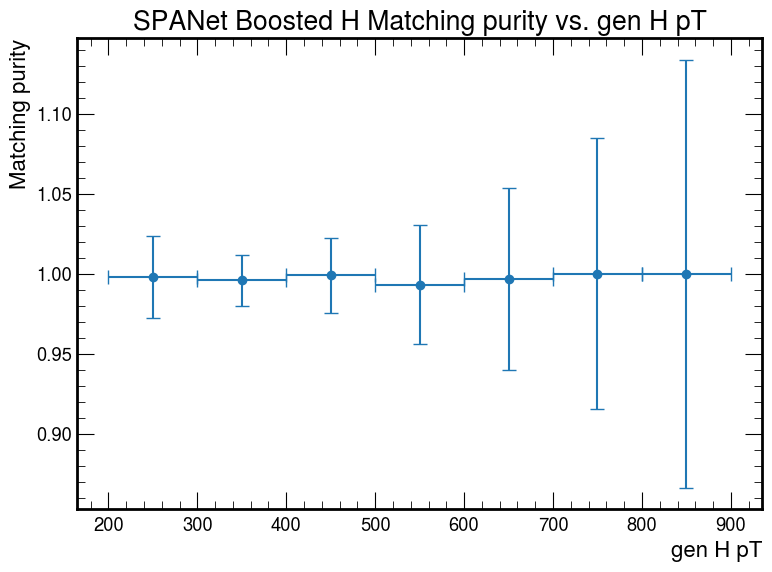

In [45]:
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(x=bin_centers, y=ak.mean(purs_per_bin, axis=-1),\
            xerr = (bins[1]-bins[0])/2*np.ones(bins.shape[0]-1),\
            yerr=1/np.sqrt(ak.count(purs_per_bin, axis=-1).to_numpy()),\
           fmt='o', capsize=5)
ax.set(xlabel=r"gen H pT", ylabel=r"Matching purity", title="SPANet Boosted H Matching purity vs. gen H pT")
plt.tight_layout()
plt.savefig(f"{str(plot_dir)}/test_purity.jpg")